<a href="https://colab.research.google.com/github/z3301/data-analysis-project/blob/main/notebooks/Forecasting%20Unsafe%20Water%20Conditions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Unsafe Water Conditions Along the California Coast
## Multi-Site Analysis: MLML Monterey Bay, Scripps Pier, and Newport Pier

**Author:** Dan Zimmerman (dzimmerman2021@fau.edu)  
**Course:** CAP5768 Introduction to Data Analytics  
**Instructor:** Dr. Fernando Koch  
**Institution:** Florida Atlantic University  
**Date:** Fall 2025

---

## Research Question

**Can unsafe water conditions at California coastal sites be predicted in advance using oceanographic sensor data?**

### Motivation

Real-time water quality monitoring is critical for protecting public health and marine ecosystems. This analysis examines 3 years of data from 3 California coastal monitoring stations to:
1. Identify site-specific drivers of unsafe conditions
2. Develop predictive models for early warning
3. Compare oceanographic patterns across latitudes

### Data Sources

| Site | Location | Provider | Date Range | Primary Driver |
|------|----------|----------|------------|----------------|
| **MLML Monterey** | 36.8°N, 121.8°W | CeNCOOS | Jan 2023 - Oct 2025 | Upwelling (Nitrate) |
| **Scripps Pier** | 32.9°N, 117.3°W | SCCOOS | Jan 2023 - Nov 2025 | Algal Blooms (Chlorophyll) |
| **Newport Pier** | 33.6°N, 117.9°W | SCCOOS | Jan 2023 - Nov 2025 | Algal Blooms (Chlorophyll) |

---

## Setup

### Running on Google Colab

Click the badge below to open this notebook in Colab:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/z3301/data-analysis-project/blob/main/notebooks/California_Coastal_Water_Quality_Analysis.ipynb)

Then run the setup cell below to clone the repository and configure paths.

In [ ]:
# Environment Setup - Run this cell first!
import sys
import os

# Detect environment
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Clone the repository (only needed once)
    if not os.path.exists('data-analysis-project'):
        print("Cloning repository...")
        !git clone https://github.com/z3301/data-analysis-project.git

    sys.path.insert(0, 'data-analysis-project/src')
    DATA_DIR = "data-analysis-project/data/processed/"
    print("Environment: Google Colab")
else:
    # Local development
    sys.path.insert(0, '../src')
    DATA_DIR = "../data/processed/"
    print("Environment: Local")

print(f"Data directory: {DATA_DIR}")

### Install Dependencies

In [ ]:
# Install required packages (uncomment if running in Colab)
!pip install pandas numpy matplotlib seaborn scikit-learn -q

### Import Libraries

In [ ]:
# Core libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')

# Machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("Libraries imported successfully")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully
Pandas version: 2.3.3
NumPy version: 2.3.5


### Import Project Modules (Optional)

The project includes custom modules for data loading, feature engineering, and classification.
These were used to generate the pre-processed datasets. You can import them for reference:

In [ ]:
# Import project-specific modules (these generated the pre-processed data)
# Each site has its own data loader, safety classifier, and feature engineer

try:
    # Data loaders (used to fetch and clean raw data from ERDDAP)
    from data_collection.mlml_data_loader import MLMLDataLoader
    from data_collection.scripps_data_loader import ScrippsDataLoader
    from data_collection.newport_data_loader import NewportDataLoader

    # Safety classifiers (apply California Ocean Plan thresholds)
    from labeling.safety_classifier_mlml import SafetyClassifierMLML
    from labeling.safety_classifier_scripps import SafetyClassifierScripps
    from labeling.safety_classifier_newport import SafetyClassifierNewport

    # Feature engineers (create lagged and rolling features)
    from data_processing.feature_engineering_mlml import FeatureEngineerMLML
    from data_processing.feature_engineering_newport import FeatureEngineerNewport

    # Experiment modules
    from experiments.experiment_1_correlation import Experiment1

    print("Project modules imported successfully")
    MODULES_AVAILABLE = True

except ImportError as e:
    print(f"Note: Project modules not available ({e})")
    print("This is fine - we'll load pre-processed data directly")
    MODULES_AVAILABLE = False

Project modules imported successfully


---

## Data Pipeline Overview

The pre-processed datasets were created using the following pipeline for each site:

```
Raw CSV from ERDDAP → Data Loader → Hourly Resampling → Safety Classifier → Feature Engineer → Featured Dataset
```

**Pipeline Steps:**
1. **Data Collection**: Raw CSV files downloaded from CeNCOOS/SCCOOS ERDDAP servers
2. **Resampling**: 3-5 minute samples aggregated to hourly means
3. **Safety Classification**: SAFE/CAUTION/DANGER labels based on California Ocean Plan thresholds
4. **Feature Engineering**: Lagged features (1h, 6h, 12h, 24h), rolling statistics, rate of change

**To regenerate the data from scratch:**
```python
python run_mlml_pipeline.py      # MLML Monterey Bay
python run_scripps_pipeline.py   # Scripps Pier
python run_newport_pipeline.py   # Newport Pier
```

---

## Part 1: Load Data from All Three Sites

Load pre-processed data from MLML Monterey Bay, Scripps Pier, and Newport Pier.

In [ ]:
# Load all three datasets
# Supports both compressed (.csv.gz) and uncompressed (.csv) files
print("Loading California coastal datasets...\n")

def load_dataset(name):
    """Load dataset, trying compressed first then uncompressed."""
    gz_path = f"{DATA_DIR}{name}_featured_dataset.csv.gz"
    csv_path = f"{DATA_DIR}{name}_featured_dataset.csv"

    if os.path.exists(gz_path):
        return pd.read_csv(gz_path, compression='gzip')
    elif os.path.exists(csv_path):
        return pd.read_csv(csv_path)
    else:
        raise FileNotFoundError(f"Dataset not found: {name}")

# MLML Monterey Bay
mlml_data = load_dataset('mlml')
mlml_data['time'] = pd.to_datetime(mlml_data['time'])
mlml_data['site'] = 'MLML Monterey'
print(f"MLML Monterey:  {len(mlml_data):,} records")

# Scripps Pier
scripps_data = load_dataset('scripps')
scripps_data['time'] = pd.to_datetime(scripps_data['time'])
scripps_data['site'] = 'Scripps Pier'
print(f"Scripps Pier:   {len(scripps_data):,} records")

# Newport Pier
newport_data = load_dataset('newport')
newport_data['time'] = pd.to_datetime(newport_data['time'])
newport_data['site'] = 'Newport Pier'
print(f"Newport Pier:   {len(newport_data):,} records")

print("\n" + "="*60)
print("DATA SUMMARY")
print("="*60)
print(f"\nTotal Records: {len(mlml_data) + len(scripps_data) + len(newport_data):,}")
print(f"\nDate Ranges:")
print(f"  MLML:    {mlml_data['time'].min().date()} to {mlml_data['time'].max().date()}")
print(f"  Scripps: {scripps_data['time'].min().date()} to {scripps_data['time'].max().date()}")
print(f"  Newport: {newport_data['time'].min().date()} to {newport_data['time'].max().date()}")

### Preview Data Structure

In [ ]:
print("="*70)
print("DATA PREVIEW - MLML MONTEREY BAY")
print("="*70)

# Key water quality columns for MLML
mlml_cols = ['time', 'water_temp', 'pH', 'dissolved_oxygen_pct', 'nitrate',
             'salinity', 'fluorescence', 'tide_height', 'safety_label']
available_mlml = [c for c in mlml_cols if c in mlml_data.columns]

print("\nKey Parameters:")
display(mlml_data[available_mlml].head(10))

print("\nStatistics:")
display(mlml_data[available_mlml].describe().round(2))

DATA PREVIEW - MLML MONTEREY BAY

Key Parameters:


,time,water_temp,pH,dissolved_oxygen_pct,nitrate,salinity,fluorescence,tide_height,safety_label
0,2023-01-01 00:00:00+00:00,13.373030,7.581112,124.372500,16.578333,32.553845,2.916409,0.798347,1
1,2023-01-01 01:00:00+00:00,13.345500,7.650350,125.389167,NaN,32.545835,2.978303,0.929564,0
2,2023-01-01 02:00:00+00:00,13.340686,7.652887,126.560000,NaN,32.530491,2.963834,0.981431,0
3,2023-01-01 03:00:00+00:00,13.334020,7.654700,128.413333,NaN,32.531196,2.991164,0.948588,0
4,2023-01-01 04:00:00+00:00,13.352111,7.635850,130.785000,NaN,32.521919,2.976696,0.850468,0
5,2023-01-01 05:00:00+00:00,13.363152,7.612650,128.387500,NaN,32.473022,3.051451,0.725399,0
6,2023-01-01 06:00:00+00:00,13.365562,7.611563,126.924167,NaN,32.488097,3.014475,0.621233,0
7,2023-01-01 07:00:00+00:00,13.279503,7.615550,124.299091,NaN,32.528425,3.072424,0.583276,0
8,2023-01-01 08:00:00+00:00,13.295441,7.615945,126.256364,20.997000,32.510895,3.111884,0.644624,1
9,2023-01-01 09:00:00+00:00,13.264929,7.608663,124.489167,22.079167,32.489700,3.071547,0.800608,1



Statistics:


,water_temp,pH,dissolved_oxygen_pct,nitrate,salinity,fluorescence,tide_height,safety_label
count,23535.00,22921.00,22129.00,19215.00,23353.00,23536.00,23528.00,24733.00
mean,13.30,7.73,76.73,20.93,33.14,4.11,0.86,0.73
std,1.79,0.25,25.93,14.85,0.56,4.47,0.50,0.63
min,8.78,6.51,0.31,-4.65,20.89,-0.80,-0.56,0.00
25%,12.01,7.62,56.76,9.06,32.94,1.36,0.52,0.00
50%,13.14,7.76,79.24,20.34,33.17,2.56,0.93,1.00
75%,14.30,7.89,95.12,30.73,33.44,4.87,1.20,1.00
max,21.52,9.15,179.53,99.52,33.95,115.00,2.08,2.00


In [ ]:
print("="*70)
print("DATA PREVIEW - SCRIPPS PIER")
print("="*70)

# Key water quality columns for Scripps
scripps_cols = ['time', 'water_temp', 'pH', 'dissolved_oxygen_pct', 'chlorophyll',
                'salinity', 'turbidity', 'safety_label']
available_scripps = [c for c in scripps_cols if c in scripps_data.columns]

print("\nKey Parameters:")
display(scripps_data[available_scripps].head(10))

print("\nStatistics:")
display(scripps_data[available_scripps].describe().round(2))

DATA PREVIEW - SCRIPPS PIER

Key Parameters:


,time,water_temp,pH,dissolved_oxygen_pct,chlorophyll,salinity,turbidity,safety_label
0,2023-01-01 00:00:00+00:00,15.084447,8.020509,100.055833,1.424000,33.343967,NaN,0
1,2023-01-01 01:00:00+00:00,15.052367,8.007288,98.157833,0.994000,33.347093,NaN,0
2,2023-01-01 02:00:00+00:00,15.035767,8.014418,97.556833,1.205333,33.347800,NaN,0
3,2023-01-01 03:00:00+00:00,14.998780,8.009222,96.656500,1.041333,33.346707,NaN,0
4,2023-01-01 04:00:00+00:00,14.890147,8.010794,96.088167,1.249333,33.340360,NaN,0
5,2023-01-01 05:00:00+00:00,14.866173,8.011483,96.497500,1.272667,33.335713,NaN,0
6,2023-01-01 06:00:00+00:00,14.861647,8.013804,97.092833,1.165333,33.330620,NaN,0
7,2023-01-01 07:00:00+00:00,14.877240,8.012021,97.326000,1.014667,33.317947,NaN,0
8,2023-01-01 08:00:00+00:00,14.879547,8.002798,97.647667,0.885333,33.294927,NaN,0
9,2023-01-01 09:00:00+00:00,14.864040,8.001946,97.573000,0.813333,33.174980,NaN,0



Statistics:


,water_temp,pH,dissolved_oxygen_pct,chlorophyll,salinity,turbidity,safety_label
count,25371.00,19442.00,18218.00,25371.00,25371.00,7229.00,25558.00
mean,17.20,7.96,92.18,17.92,33.09,4.83,0.39
std,2.73,0.21,23.86,26.05,0.99,18.41,0.56
min,11.31,7.09,0.02,-0.58,19.08,0.03,0.00
25%,14.97,7.95,85.75,0.83,33.11,0.37,0.00
50%,16.84,8.02,97.52,2.53,33.27,0.63,0.00
75%,18.97,8.07,105.14,29.74,33.43,1.27,1.00
max,24.56,8.43,179.90,74.42,33.79,101.54,2.00


In [ ]:
print("="*70)
print("DATA PREVIEW - NEWPORT PIER")
print("="*70)

# Key water quality columns for Newport
newport_cols = ['time', 'water_temp', 'pH', 'dissolved_oxygen_pct', 'chlorophyll',
                'salinity', 'safety_label']
available_newport = [c for c in newport_cols if c in newport_data.columns]

print("\nKey Parameters:")
display(newport_data[available_newport].head(10))

print("\nStatistics:")
display(newport_data[available_newport].describe().round(2))

DATA PREVIEW - NEWPORT PIER

Key Parameters:


,time,water_temp,pH,dissolved_oxygen_pct,chlorophyll,salinity,safety_label
0,2023-01-01 00:00:00+00:00,15.711787,8.000000,NaN,0.356667,33.354547,0
1,2023-01-01 01:00:00+00:00,15.683680,8.003333,NaN,0.440000,33.357340,0
2,2023-01-01 02:00:00+00:00,15.648980,8.001333,NaN,0.476000,33.352573,0
3,2023-01-01 03:00:00+00:00,15.676000,8.014000,NaN,0.272000,33.385200,0
4,2023-01-01 04:00:00+00:00,15.689987,8.020000,NaN,0.228667,33.391560,0
5,2023-01-01 05:00:00+00:00,15.704627,8.018000,NaN,0.220667,33.384067,0
6,2023-01-01 06:00:00+00:00,15.710800,8.016923,NaN,0.206000,33.326920,0
7,2023-01-01 07:00:00+00:00,15.709620,8.020000,NaN,0.200000,33.294527,0
8,2023-01-01 08:00:00+00:00,15.710760,8.021429,NaN,0.200000,33.301880,0
9,2023-01-01 09:00:00+00:00,15.699760,8.018462,NaN,0.172000,33.311853,0



Statistics:


,water_temp,pH,dissolved_oxygen_pct,chlorophyll,salinity,safety_label
count,24963.00,25021.00,22669.00,20813.00,24667.00,25555.00
mean,17.24,7.99,95.75,10.08,33.11,0.16
std,2.60,0.11,10.62,17.60,0.50,0.36
min,11.28,7.12,36.60,0.00,28.96,0.00
25%,14.99,7.96,89.62,0.74,33.02,0.00
50%,17.14,7.99,94.43,1.78,33.24,0.00
75%,19.04,8.03,101.13,7.74,33.38,0.00
max,24.31,8.61,199.59,70.00,33.93,1.00


---

## Part 2: Safety Classification Comparison

Compare safety classifications across all three sites.

In [ ]:
# Calculate label distributions for all sites
sites = {
    'MLML Monterey': mlml_data,
    'Scripps Pier': scripps_data,
    'Newport Pier': newport_data
}

label_names = {0: 'SAFE', 1: 'CAUTION', 2: 'DANGER'}

print("="*80)
print("SAFETY LABEL DISTRIBUTION BY SITE")
print("="*80)

site_stats = []

for site_name, data in sites.items():
    total = len(data)
    label_counts = data['safety_label'].value_counts().sort_index()

    print(f"\n{site_name}:")
    print("-" * 40)

    for label in [0, 1, 2]:
        count = label_counts.get(label, 0)
        pct = count / total * 100
        print(f"  {label_names[label]:8s}: {count:6,} records ({pct:5.1f}%)")

    site_stats.append({
        'Site': site_name,
        'Total': total,
        'SAFE': label_counts.get(0, 0),
        'SAFE %': label_counts.get(0, 0) / total * 100,
        'CAUTION': label_counts.get(1, 0),
        'CAUTION %': label_counts.get(1, 0) / total * 100,
        'DANGER': label_counts.get(2, 0),
        'DANGER %': label_counts.get(2, 0) / total * 100
    })

# Summary table
summary_df = pd.DataFrame(site_stats)
print("\n" + "="*80)
print("SUMMARY TABLE")
print("="*80)
display(summary_df.round(1))

SAFETY LABEL DISTRIBUTION BY SITE

MLML Monterey:
----------------------------------------
  SAFE    :  9,041 records ( 36.6%)
  CAUTION : 13,264 records ( 53.6%)
  DANGER  :  2,428 records (  9.8%)

Scripps Pier:
----------------------------------------
  SAFE    : 16,421 records ( 64.2%)
  CAUTION :  8,179 records ( 32.0%)
  DANGER  :    958 records (  3.7%)

Newport Pier:
----------------------------------------
  SAFE    : 21,568 records ( 84.4%)
  CAUTION :  3,987 records ( 15.6%)
  DANGER  :      0 records (  0.0%)

SUMMARY TABLE


,Site,Total,SAFE,SAFE %,CAUTION,CAUTION %,DANGER,DANGER %
0,MLML Monterey,24733,9041,36.6,13264,53.6,2428,9.8
1,Scripps Pier,25558,16421,64.2,8179,32.0,958,3.7
2,Newport Pier,25555,21568,84.4,3987,15.6,0,0.0


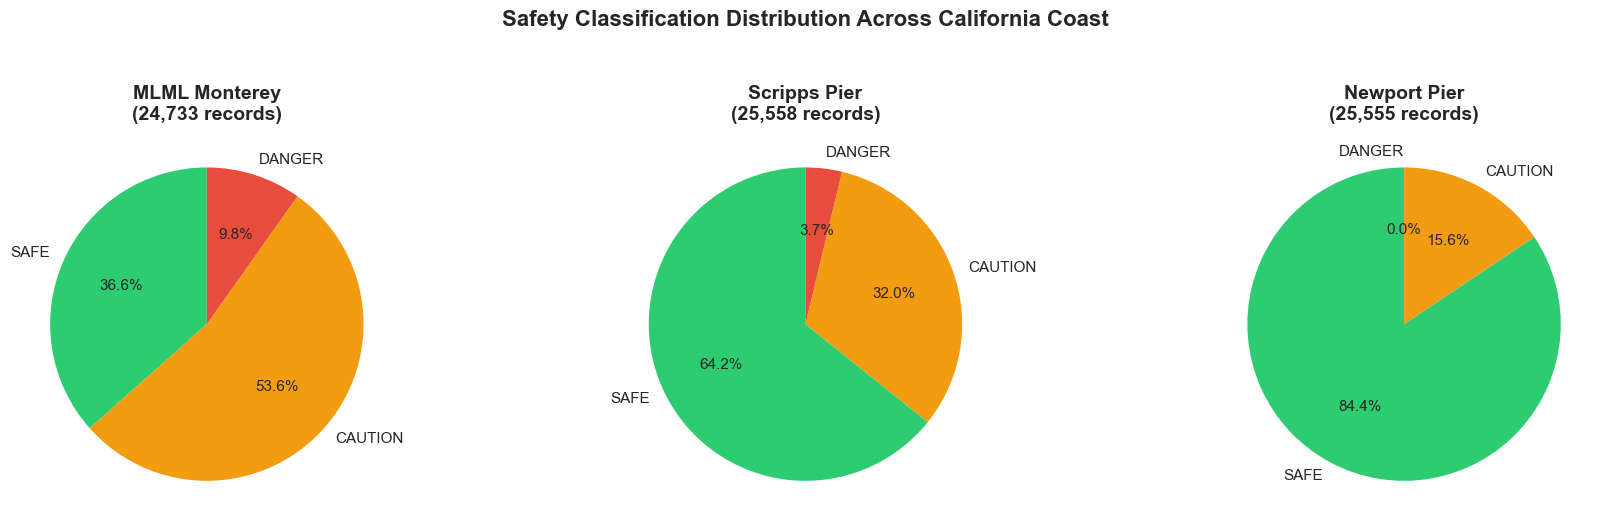

In [ ]:
# Visualize label distribution across sites
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

colors = ['#2ecc71', '#f39c12', '#e74c3c']
labels = ['SAFE', 'CAUTION', 'DANGER']

for idx, (site_name, data) in enumerate(sites.items()):
    label_counts = data['safety_label'].value_counts().sort_index()
    sizes = [label_counts.get(i, 0) for i in range(3)]

    # Pie chart
    axes[idx].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
                  startangle=90, textprops={'fontsize': 11})
    axes[idx].set_title(f'{site_name}\n({len(data):,} records)',
                        fontsize=14, fontweight='bold')

plt.suptitle('Safety Classification Distribution Across California Coast',
             fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

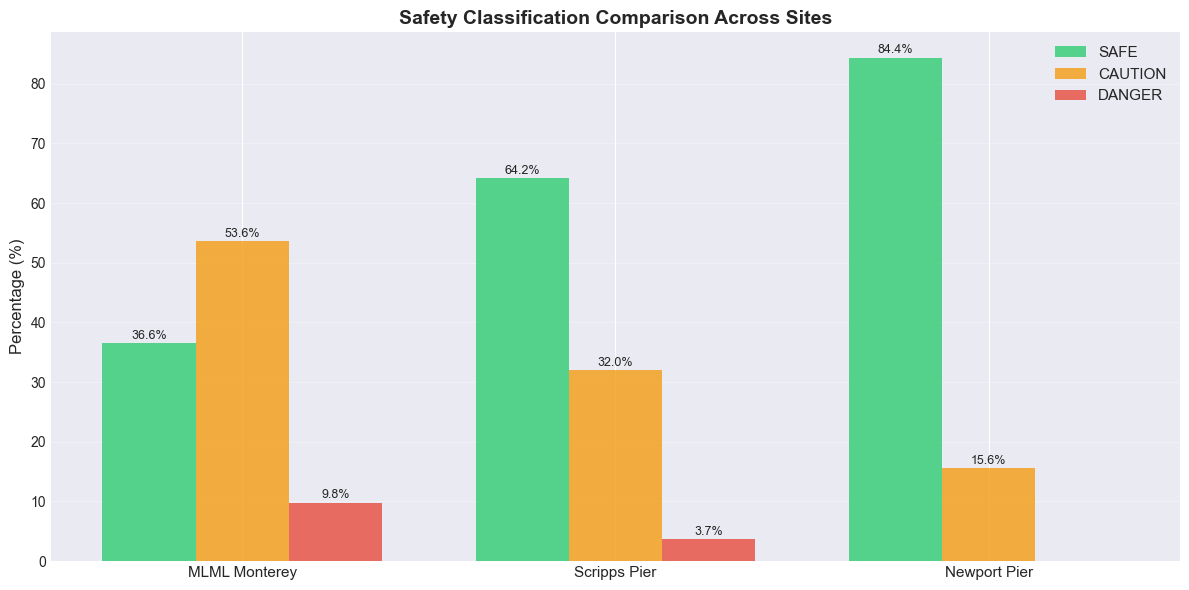

In [ ]:
# Bar chart comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(3)  # Site positions
width = 0.25

# Get percentages
safe_pcts = [summary_df.loc[i, 'SAFE %'] for i in range(3)]
caution_pcts = [summary_df.loc[i, 'CAUTION %'] for i in range(3)]
danger_pcts = [summary_df.loc[i, 'DANGER %'] for i in range(3)]

bars1 = ax.bar(x - width, safe_pcts, width, label='SAFE', color='#2ecc71', alpha=0.8)
bars2 = ax.bar(x, caution_pcts, width, label='CAUTION', color='#f39c12', alpha=0.8)
bars3 = ax.bar(x + width, danger_pcts, width, label='DANGER', color='#e74c3c', alpha=0.8)

ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_title('Safety Classification Comparison Across Sites', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(summary_df['Site'], fontsize=11)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        if height > 2:
            ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                       xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)

plt.tight_layout()
plt.show()

### Geographic Pattern Analysis

### Geographic Pattern: Latitude Gradient

The data reveals a clear **north-to-south gradient** in water quality:

| Latitude | Site | Zone | Primary Driver | DANGER % |
|----------|------|------|----------------|----------|
| 36.8°N | MLML Monterey | Upwelling Zone | Nitrate-driven | 9.8% |
| 33.6°N | Newport Pier | Coastal Southern CA | Chlorophyll-driven | 0.0% |
| 32.9°N | Scripps Pier | Coastal Southern CA | Chlorophyll-driven | 3.7% |

**Key Insight:** Northern California (Monterey Bay) is dominated by **coastal upwelling**, while Southern California sites are dominated by **algal blooms**.

---

## EXPERIMENT 1: Environmental Drivers (Per Site)

**Question:** Which variables most influence unsafe water conditions at each site?

**Techniques:**
- Correlation analysis
- Feature importance ranking

In [ ]:
def analyze_correlations(data, site_name, top_n=15):
    """Calculate and display correlations with safety label."""
    # Get numeric columns
    numeric_cols = data.select_dtypes(include=[np.number]).columns

    # Exclude metadata columns
    exclude = ['safety_label', 'hour', 'day_of_week', 'month', 'day_of_year',
               'season', 'is_day', 'is_flooding', 'is_ebbing', 'is_low_tide',
               'is_high_tide', 'tide_above_mean']
    feature_cols = [c for c in numeric_cols if c not in exclude]

    # Calculate correlations
    correlations = {}
    for col in feature_cols:
        valid = data[[col, 'safety_label']].dropna()
        if len(valid) > 100:
            corr = valid[col].corr(valid['safety_label'])
            if not np.isnan(corr):
                correlations[col] = corr

    # Sort by absolute value
    sorted_corr = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)

    print(f"\n{'='*70}")
    print(f"{site_name.upper()} - TOP {top_n} CORRELATIONS WITH UNSAFE CONDITIONS")
    print(f"{'='*70}")

    print(f"\nPositive correlations (higher = more unsafe):")
    print("-" * 50)
    positive = [(k, v) for k, v in sorted_corr if v > 0][:top_n]
    for feat, val in positive:
        print(f"  {feat:45s}: {val:+.4f}")

    print(f"\nNegative correlations (lower = more unsafe):")
    print("-" * 50)
    negative = [(k, v) for k, v in sorted_corr if v < 0][:5]
    for feat, val in negative:
        print(f"  {feat:45s}: {val:+.4f}")

    return dict(sorted_corr)

# Analyze each site
mlml_corr = analyze_correlations(mlml_data, 'MLML Monterey')
scripps_corr = analyze_correlations(scripps_data, 'Scripps Pier')
newport_corr = analyze_correlations(newport_data, 'Newport Pier')


MLML MONTEREY - TOP 15 CORRELATIONS WITH UNSAFE CONDITIONS

Positive correlations (higher = more unsafe):
--------------------------------------------------
  is_unsafe                                    : +0.8879
  nitrate                                      : +0.7617
  nitrate_lag_1h                               : +0.7091
  upwelling_index                              : +0.6998
  nitrate_rolling_mean_6h                      : +0.6844
  nitrate_rolling_min_6h                       : +0.6606
  nitrate_rolling_mean_12h                     : +0.6555
  nitrate_rolling_max_6h                       : +0.6523
  nitrate_rolling_mean_24h                     : +0.6273
  nitrate_rolling_max_12h                      : +0.6167
  nitrate_rolling_min_12h                      : +0.5997
  nitrate_lag_12h                              : +0.5970
  nitrate_rolling_mean_48h                     : +0.5935
  nitrate_lag_24h                              : +0.5676
  nitrate_rolling_min_24h                   

In [ ]:
# Compare top predictors across sites
print("="*80)
print("TOP PREDICTOR COMPARISON ACROSS SITES")
print("="*80)

# Get top predictor for each site
top_mlml = list(mlml_corr.items())[0] if mlml_corr else ('N/A', 0)
top_scripps = list(scripps_corr.items())[0] if scripps_corr else ('N/A', 0)
top_newport = list(newport_corr.items())[0] if newport_corr else ('N/A', 0)

print(f"""
┌─────────────────┬────────────────────────┬─────────────┐
│ Site            │ Top Predictor          │ Correlation │
├─────────────────┼────────────────────────┼─────────────┤
│ MLML Monterey   │ {top_mlml[0]:22s} │   r = {top_mlml[1]:+.3f} │
│ Scripps Pier    │ {top_scripps[0]:22s} │   r = {top_scripps[1]:+.3f} │
│ Newport Pier    │ {top_newport[0]:22s} │   r = {top_newport[1]:+.3f} │
└─────────────────┴────────────────────────┴─────────────┘
""")

print("INTERPRETATION:")
print("  • MLML Monterey: Dominated by UPWELLING (nitrate is key indicator)")
print("  • Scripps Pier:  Dominated by ALGAL BLOOMS (chlorophyll)")
print("  • Newport Pier:  Dominated by ALGAL BLOOMS (chlorophyll) - very strong signal")

TOP PREDICTOR COMPARISON ACROSS SITES

┌─────────────────┬────────────────────────┬─────────────┐
│ Site            │ Top Predictor          │ Correlation │
├─────────────────┼────────────────────────┼─────────────┤
│ MLML Monterey   │ is_unsafe              │   r = +0.888 │
│ Scripps Pier    │ chlorophyll            │   r = +0.665 │
│ Newport Pier    │ chlorophyll            │   r = +0.860 │
└─────────────────┴────────────────────────┴─────────────┘

INTERPRETATION:
  • MLML Monterey: Dominated by UPWELLING (nitrate is key indicator)
  • Scripps Pier:  Dominated by ALGAL BLOOMS (chlorophyll)
  • Newport Pier:  Dominated by ALGAL BLOOMS (chlorophyll) - very strong signal


### Correlation Heatmaps by Site

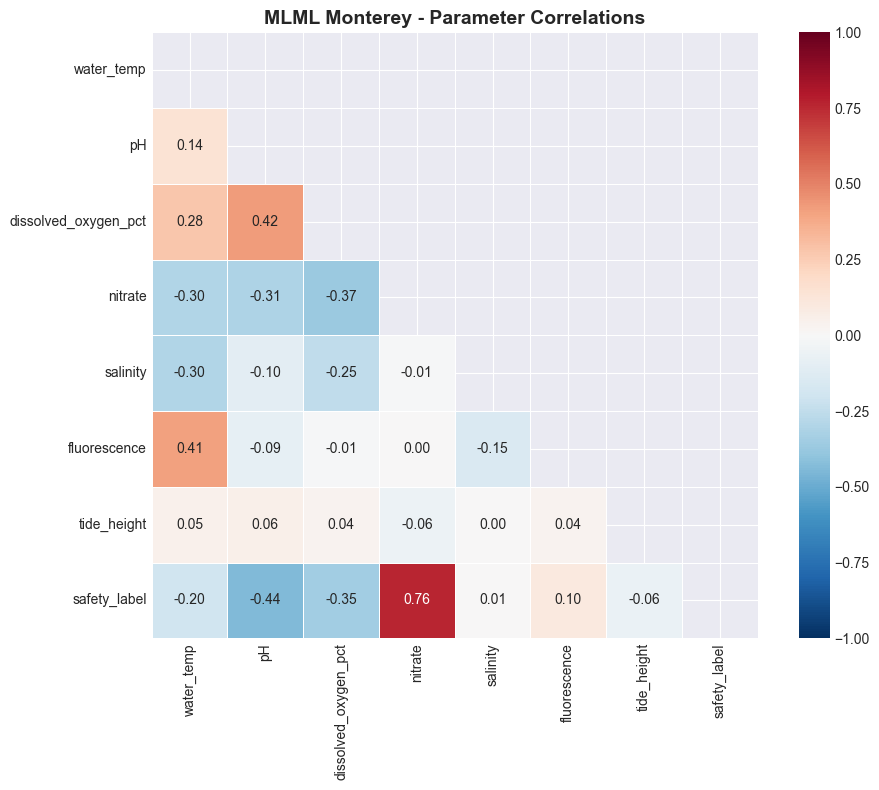

In [ ]:
def create_correlation_heatmap(data, site_name, params):
    """Create correlation heatmap for a site (lower triangle only)."""
    available = [p for p in params if p in data.columns]
    available.append('safety_label')

    corr_matrix = data[available].corr()

    # Create mask for upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
                center=0, vmin=-1, vmax=1, square=True, linewidths=0.5)
    plt.title(f'{site_name} - Parameter Correlations', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# MLML parameters
mlml_params = ['water_temp', 'pH', 'dissolved_oxygen_pct', 'nitrate',
               'salinity', 'fluorescence', 'tide_height']
create_correlation_heatmap(mlml_data, 'MLML Monterey', mlml_params)

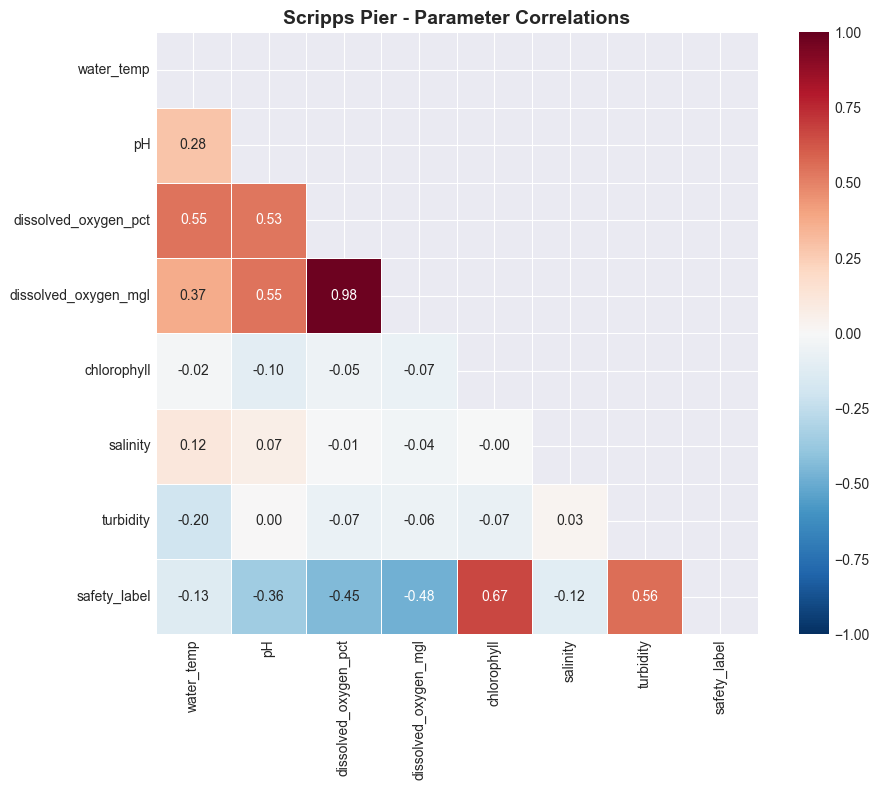

In [ ]:
# Scripps parameters
scripps_params = ['water_temp', 'pH', 'dissolved_oxygen_pct', 'dissolved_oxygen_mgl',
                  'chlorophyll', 'salinity', 'turbidity']
create_correlation_heatmap(scripps_data, 'Scripps Pier', scripps_params)

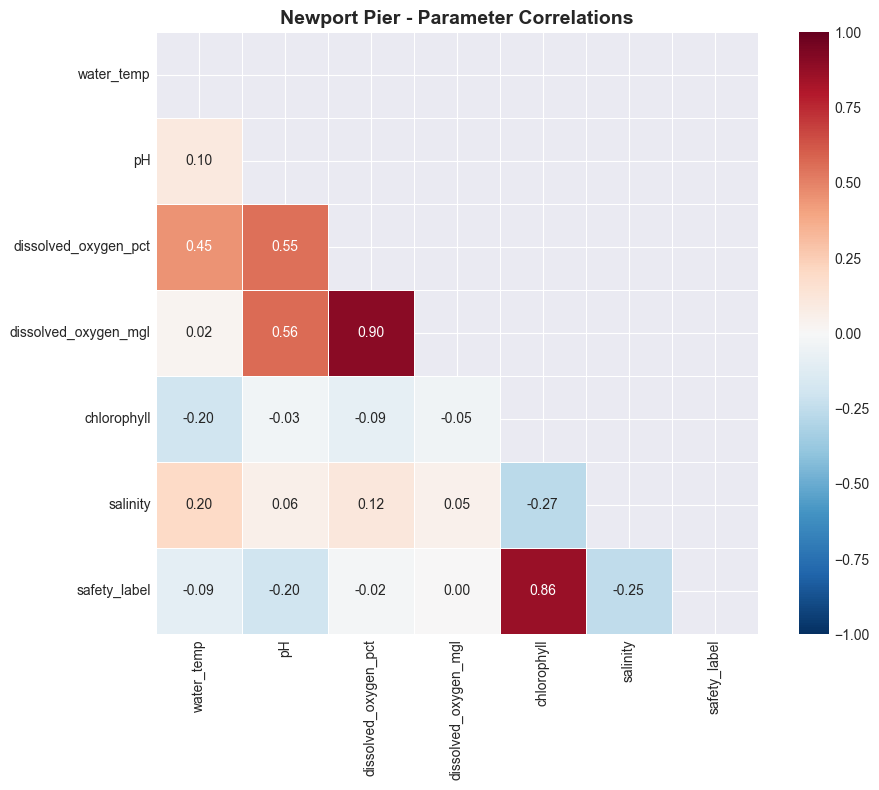

In [ ]:
# Newport parameters
newport_params = ['water_temp', 'pH', 'dissolved_oxygen_pct', 'dissolved_oxygen_mgl',
                  'chlorophyll', 'salinity']
create_correlation_heatmap(newport_data, 'Newport Pier', newport_params)

### Feature Importance Comparison

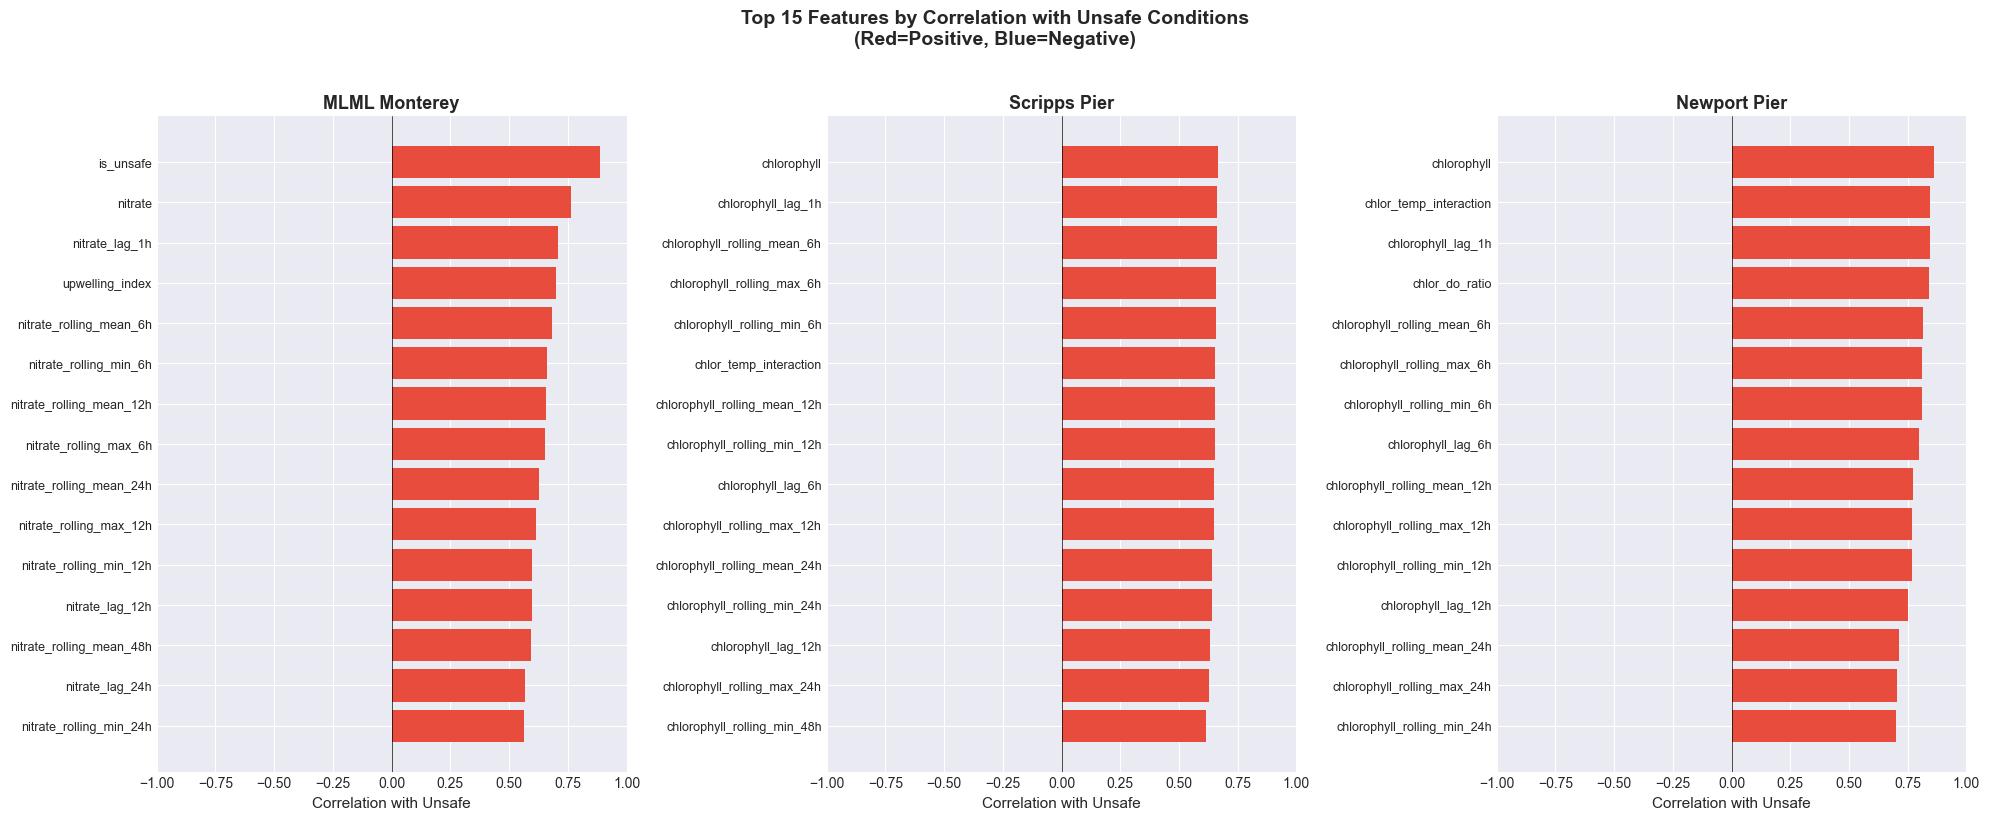

In [ ]:
# Plot top 15 features for each site
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

site_correlations = [
    ('MLML Monterey', mlml_corr),
    ('Scripps Pier', scripps_corr),
    ('Newport Pier', newport_corr)
]

for idx, (site_name, corr_dict) in enumerate(site_correlations):
    ax = axes[idx]

    # Get top 15 by absolute value
    sorted_items = sorted(corr_dict.items(), key=lambda x: abs(x[1]), reverse=True)[:15]
    features = [x[0] for x in sorted_items]
    values = [x[1] for x in sorted_items]
    colors = ['#e74c3c' if v > 0 else '#3498db' for v in values]

    ax.barh(range(len(features)), values, color=colors)
    ax.set_yticks(range(len(features)))
    ax.set_yticklabels(features, fontsize=9)
    ax.invert_yaxis()
    ax.axvline(x=0, color='black', linewidth=0.5)
    ax.set_xlabel('Correlation with Unsafe', fontsize=11)
    ax.set_title(f'{site_name}', fontsize=13, fontweight='bold')
    ax.set_xlim(-1, 1)

plt.suptitle('Top 15 Features by Correlation with Unsafe Conditions\n(Red=Positive, Blue=Negative)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### Time Series Visualization

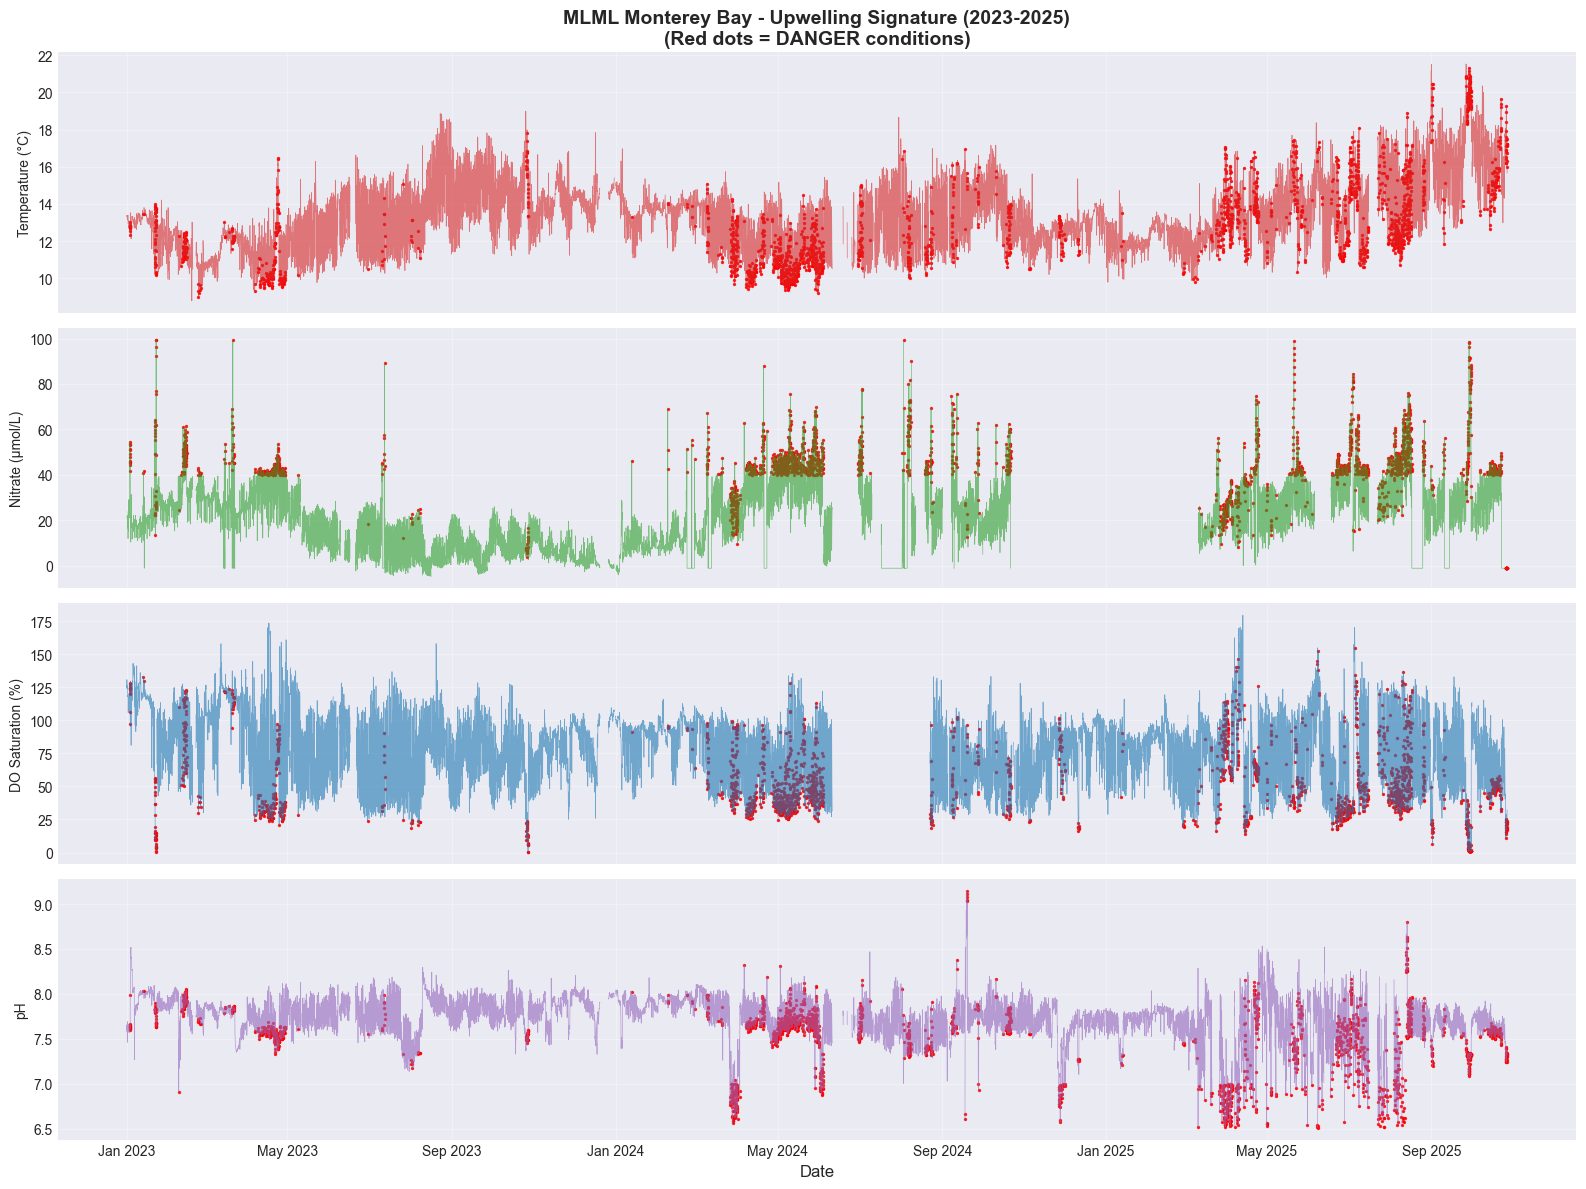

In [ ]:
# Time series for MLML (showing upwelling signature)
fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True)

params = [('water_temp', 'Temperature (°C)', 'tab:red'),
          ('nitrate', 'Nitrate (µmol/L)', 'tab:green'),
          ('dissolved_oxygen_pct', 'DO Saturation (%)', 'tab:blue'),
          ('pH', 'pH', 'tab:purple')]

for ax, (param, label, color) in zip(axes, params):
    if param in mlml_data.columns:
        ax.plot(mlml_data['time'], mlml_data[param], color=color, alpha=0.6, linewidth=0.5)
        ax.set_ylabel(label, fontsize=10)
        ax.grid(True, alpha=0.3)

        # Highlight DANGER periods
        danger_mask = mlml_data['safety_label'] == 2
        if danger_mask.any():
            ax.scatter(mlml_data.loc[danger_mask, 'time'],
                      mlml_data.loc[danger_mask, param],
                      color='red', s=2, alpha=0.8)

axes[0].set_title('MLML Monterey Bay - Upwelling Signature (2023-2025)\n(Red dots = DANGER conditions)',
                  fontsize=14, fontweight='bold')
axes[-1].set_xlabel('Date', fontsize=12)
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.tight_layout()
plt.show()

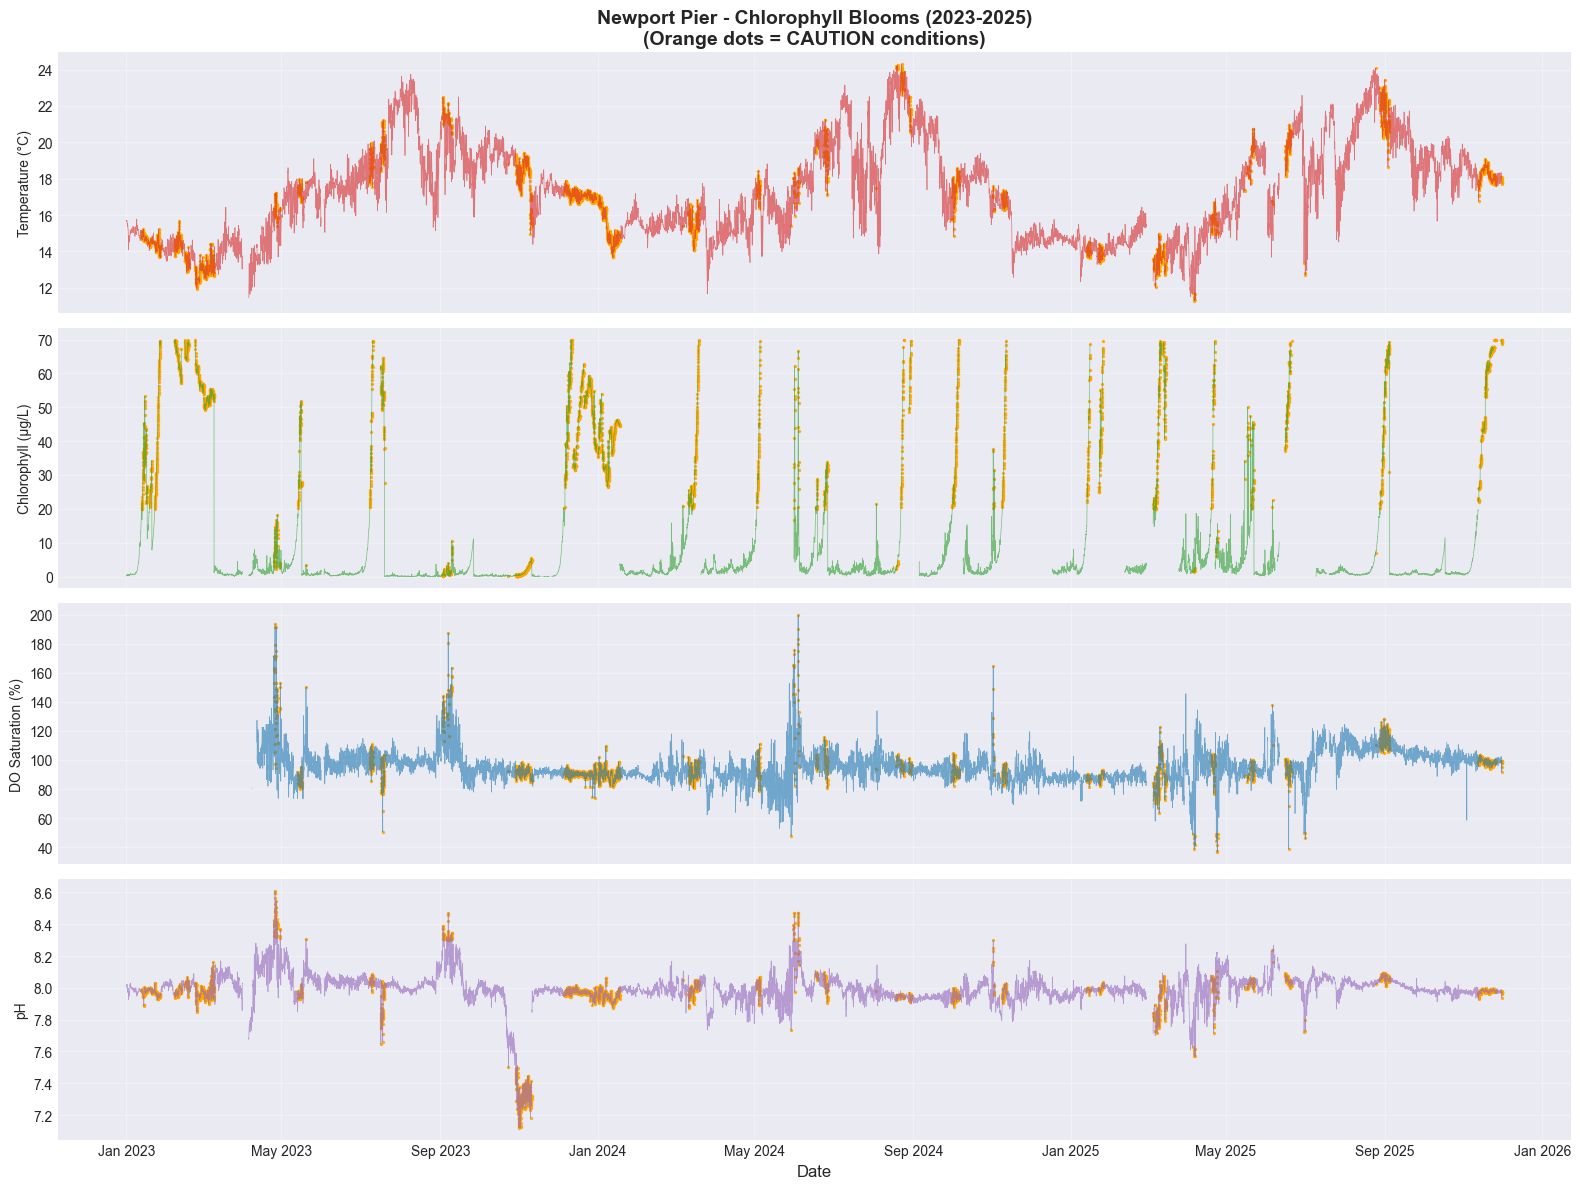

In [ ]:
# Time series for Newport (showing bloom events)
fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True)

params = [('water_temp', 'Temperature (°C)', 'tab:red'),
          ('chlorophyll', 'Chlorophyll (µg/L)', 'tab:green'),
          ('dissolved_oxygen_pct', 'DO Saturation (%)', 'tab:blue'),
          ('pH', 'pH', 'tab:purple')]

for ax, (param, label, color) in zip(axes, params):
    if param in newport_data.columns:
        ax.plot(newport_data['time'], newport_data[param], color=color, alpha=0.6, linewidth=0.5)
        ax.set_ylabel(label, fontsize=10)
        ax.grid(True, alpha=0.3)

        # Highlight CAUTION periods (no DANGER at Newport)
        caution_mask = newport_data['safety_label'] == 1
        if caution_mask.any():
            ax.scatter(newport_data.loc[caution_mask, 'time'],
                      newport_data.loc[caution_mask, param],
                      color='orange', s=2, alpha=0.8)

axes[0].set_title('Newport Pier - Chlorophyll Blooms (2023-2025)\n(Orange dots = CAUTION conditions)',
                  fontsize=14, fontweight='bold')
axes[-1].set_xlabel('Date', fontsize=12)
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.tight_layout()
plt.show()

---

## EXPERIMENT 2: Predictive Classification

**Question:** Can we predict unsafe conditions using machine learning?

**Models:**
- Logistic Regression (baseline)
- Naive Bayes (probabilistic)
- Random Forest (nonlinear)

In [ ]:
def train_and_evaluate_models(data, site_name, feature_subset=None):
    """Train classification models for a site."""
    print(f"\n{'='*70}")
    print(f"TRAINING MODELS FOR {site_name.upper()}")
    print(f"{'='*70}")

    # Prepare data
    modeling_data = data.dropna(subset=['safety_label']).copy()

    # Get numeric features
    exclude_cols = ['time', 'safety_label', 'site']
    numeric_cols = modeling_data.select_dtypes(include=[np.number]).columns
    feature_cols = [c for c in numeric_cols if c not in exclude_cols]

    # Use lagged features primarily
    lag_features = [c for c in feature_cols if 'lag' in c or 'rolling' in c or 'roc' in c]
    if len(lag_features) < 10:
        lag_features = feature_cols[:50]  # Fallback

    X = modeling_data[lag_features].fillna(0)
    y = modeling_data['safety_label']

    print(f"\nDataset: {len(X):,} records, {len(lag_features)} features")

    # Time-series split
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    print(f"Training: {len(X_train):,} | Testing: {len(X_test):,}")
    print(f"\nTest set distribution:")
    for label in [0, 1, 2]:
        count = (y_test == label).sum()
        print(f"  {['SAFE', 'CAUTION', 'DANGER'][label]}: {count}")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train models
    models = {}
    results = {}

    # Logistic Regression
    lr = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED, class_weight='balanced')
    lr.fit(X_train_scaled, y_train)
    models['Logistic Regression'] = lr

    # Naive Bayes
    nb = GaussianNB()
    nb.fit(X_train_scaled, y_train)
    models['Naive Bayes'] = nb

    # Random Forest
    rf = RandomForestClassifier(n_estimators=100, max_depth=10,
                                random_state=RANDOM_SEED, class_weight='balanced', n_jobs=-1)
    rf.fit(X_train, y_train)
    models['Random Forest'] = rf

    # Evaluate
    print("\nModel Performance:")
    print("-" * 60)

    for model_name, model in models.items():
        if model_name == 'Random Forest':
            y_pred = model.predict(X_test)
        else:
            y_pred = model.predict(X_test_scaled)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        recall_per_class = recall_score(y_test, y_pred, average=None, zero_division=0)
        danger_recall = recall_per_class[2] if len(recall_per_class) > 2 else 0

        results[model_name] = {
            'accuracy': acc,
            'f1': f1,
            'danger_recall': danger_recall,
            'predictions': y_pred
        }

        print(f"  {model_name:25s} Acc: {acc:.3f}  F1: {f1:.3f}  DANGER Recall: {danger_recall:.3f}")

    return models, results, y_test

# Train models for each site
mlml_models, mlml_results, mlml_y_test = train_and_evaluate_models(mlml_data, 'MLML Monterey')
scripps_models, scripps_results, scripps_y_test = train_and_evaluate_models(scripps_data, 'Scripps Pier')
newport_models, newport_results, newport_y_test = train_and_evaluate_models(newport_data, 'Newport Pier')


TRAINING MODELS FOR MLML MONTEREY

Dataset: 24,733 records, 207 features
Training: 19,786 | Testing: 4,947

Test set distribution:
  SAFE: 712
  CAUTION: 3229
  DANGER: 1006

Model Performance:
------------------------------------------------------------
  Logistic Regression       Acc: 0.626  F1: 0.634  DANGER Recall: 0.881
  Naive Bayes               Acc: 0.653  F1: 0.650  DANGER Recall: 0.575
  Random Forest             Acc: 0.871  F1: 0.868  DANGER Recall: 0.716

TRAINING MODELS FOR SCRIPPS PIER

Dataset: 25,558 records, 126 features
Training: 20,446 | Testing: 5,112

Test set distribution:
  SAFE: 3804
  CAUTION: 1276
  DANGER: 32

Model Performance:
------------------------------------------------------------
  Logistic Regression       Acc: 0.929  F1: 0.931  DANGER Recall: 0.000
  Naive Bayes               Acc: 0.922  F1: 0.931  DANGER Recall: 0.000
  Random Forest             Acc: 0.959  F1: 0.955  DANGER Recall: 0.000

TRAINING MODELS FOR NEWPORT PIER

Dataset: 25,555 records

### Confusion Matrices

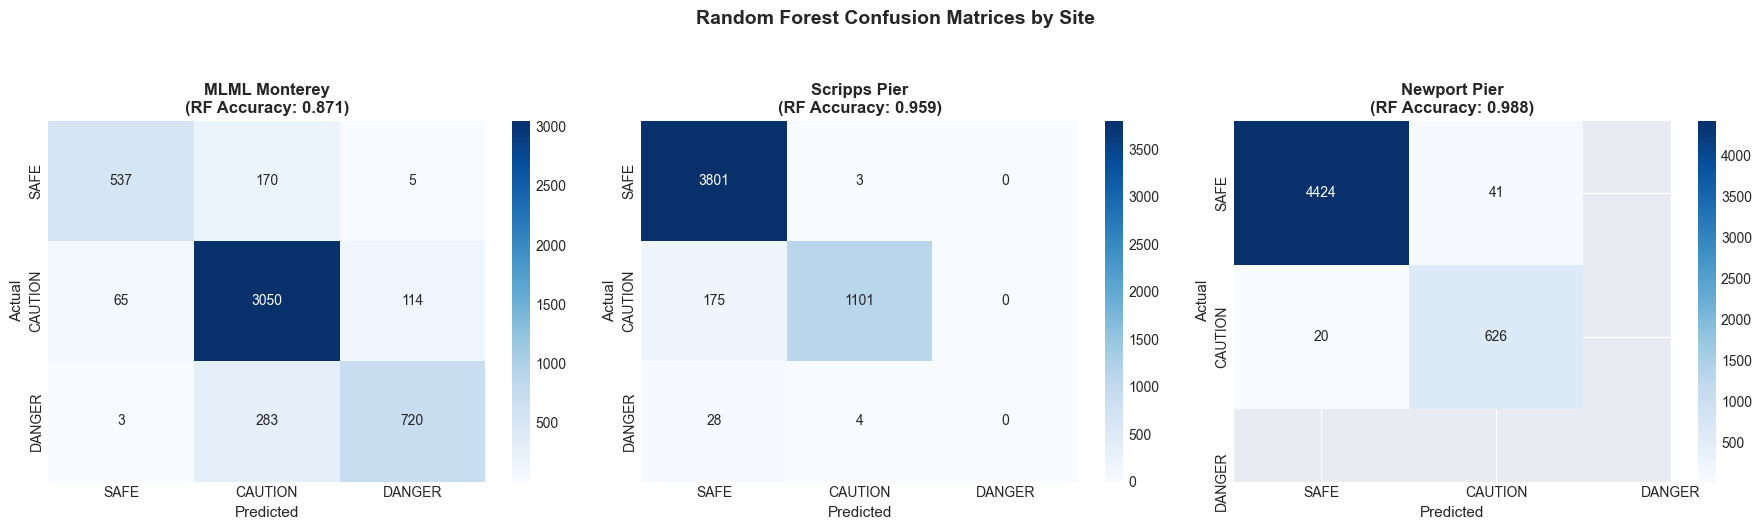

In [ ]:
# Confusion matrices for Random Forest (best model) at each site
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

site_results = [
    ('MLML Monterey', mlml_results, mlml_y_test),
    ('Scripps Pier', scripps_results, scripps_y_test),
    ('Newport Pier', newport_results, newport_y_test)
]

for idx, (site_name, results, y_test) in enumerate(site_results):
    cm = confusion_matrix(y_test, results['Random Forest']['predictions'])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['SAFE', 'CAUTION', 'DANGER'],
                yticklabels=['SAFE', 'CAUTION', 'DANGER'],
                ax=axes[idx])

    axes[idx].set_xlabel('Predicted', fontsize=11)
    axes[idx].set_ylabel('Actual', fontsize=11)
    acc = results['Random Forest']['accuracy']
    axes[idx].set_title(f'{site_name}\n(RF Accuracy: {acc:.3f})', fontsize=12, fontweight='bold')

plt.suptitle('Random Forest Confusion Matrices by Site', fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

### Model Performance Comparison

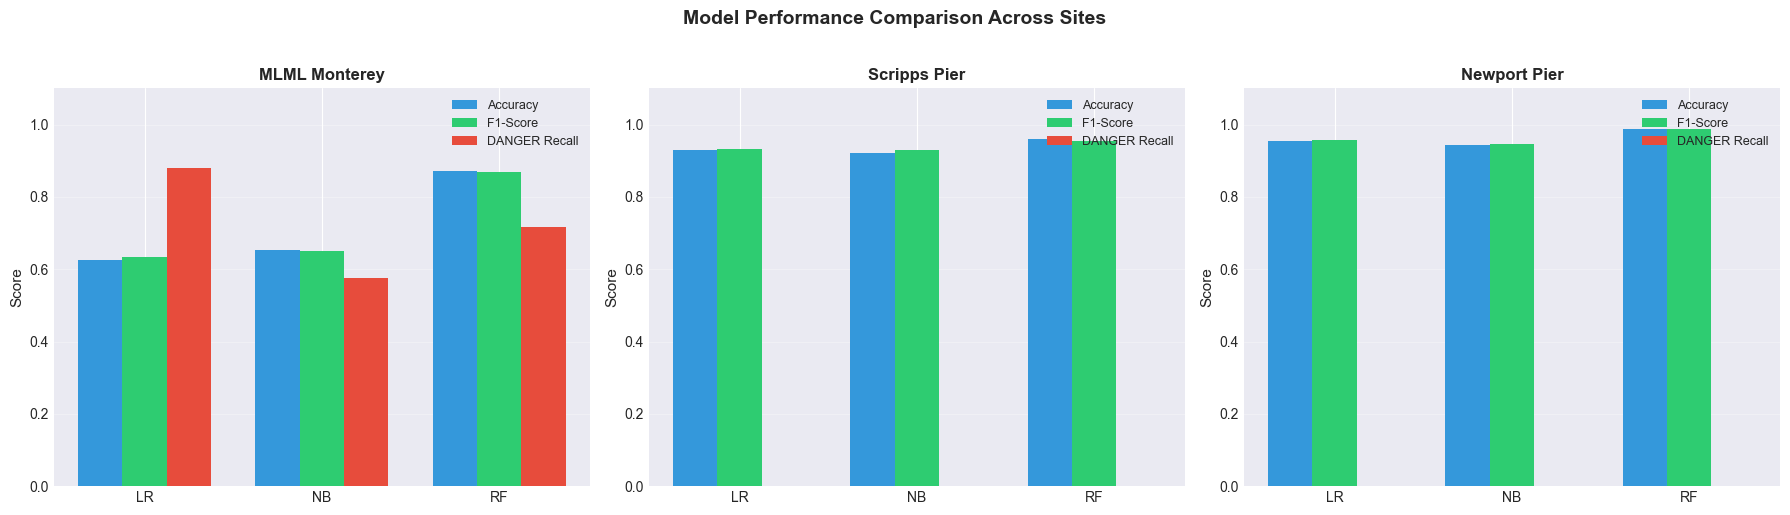

In [ ]:
# Create comparison chart
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

all_results = [
    ('MLML Monterey', mlml_results),
    ('Scripps Pier', scripps_results),
    ('Newport Pier', newport_results)
]

for idx, (site_name, results) in enumerate(all_results):
    ax = axes[idx]

    models = list(results.keys())
    acc_vals = [results[m]['accuracy'] for m in models]
    f1_vals = [results[m]['f1'] for m in models]
    dr_vals = [results[m]['danger_recall'] for m in models]

    x = np.arange(len(models))
    width = 0.25

    ax.bar(x - width, acc_vals, width, label='Accuracy', color='#3498db')
    ax.bar(x, f1_vals, width, label='F1-Score', color='#2ecc71')
    ax.bar(x + width, dr_vals, width, label='DANGER Recall', color='#e74c3c')

    ax.set_ylabel('Score', fontsize=11)
    ax.set_title(f'{site_name}', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(['LR', 'NB', 'RF'], fontsize=10)
    ax.set_ylim(0, 1.1)
    ax.legend(fontsize=9)
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Model Performance Comparison Across Sites', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---

## EXPERIMENT 3: Clustering Analysis

**Question:** Do natural water quality regimes exist at each site?

**Technique:** K-Means Clustering with PCA visualization

In [ ]:
def perform_clustering(data, site_name, cluster_params, n_clusters=4):
    """Perform K-means clustering for a site."""
    print(f"\n{'='*70}")
    print(f"CLUSTERING ANALYSIS - {site_name.upper()}")
    print(f"{'='*70}")

    # Prepare data
    available_params = [p for p in cluster_params if p in data.columns]
    X_cluster = data[available_params].dropna()
    y_cluster = data.loc[X_cluster.index, 'safety_label']

    print(f"\nClustering on: {available_params}")
    print(f"Records: {len(X_cluster):,}")

    # Scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_cluster)

    # K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_SEED, n_init=20)
    clusters = kmeans.fit_predict(X_scaled)

    # Distribution
    print(f"\nCluster Distribution:")
    for i in range(n_clusters):
        count = (clusters == i).sum()
        pct = count / len(clusters) * 100
        print(f"  Cluster {i}: {count:6,} ({pct:5.1f}%)")

    # Cluster characteristics
    cluster_df = X_cluster.copy()
    cluster_df['cluster'] = clusters
    cluster_df['safety_label'] = y_cluster

    print(f"\nCluster Characteristics:")
    for i in range(n_clusters):
        print(f"\n  Cluster {i}:")
        cluster_data = cluster_df[cluster_df['cluster'] == i]

        for param in available_params[:4]:
            mean_val = cluster_data[param].mean()
            print(f"    {param:25s}: {mean_val:7.2f}")

        # Safety distribution
        safety_dist = cluster_data['safety_label'].value_counts(normalize=True) * 100
        print(f"    Safety: SAFE={safety_dist.get(0, 0):.1f}% CAUTION={safety_dist.get(1, 0):.1f}% DANGER={safety_dist.get(2, 0):.1f}%")

    return X_scaled, clusters, y_cluster

# MLML clustering
mlml_cluster_params = ['water_temp', 'pH', 'dissolved_oxygen_pct', 'nitrate', 'salinity', 'fluorescence']
mlml_X_scaled, mlml_clusters, mlml_y_cluster = perform_clustering(mlml_data, 'MLML Monterey', mlml_cluster_params)


CLUSTERING ANALYSIS - MLML MONTEREY

Clustering on: ['water_temp', 'pH', 'dissolved_oxygen_pct', 'nitrate', 'salinity', 'fluorescence']
Records: 17,598

Cluster Distribution:
  Cluster 0:  2,243 ( 12.7%)
  Cluster 1:  6,119 ( 34.8%)
  Cluster 2:  9,189 ( 52.2%)
  Cluster 3:     47 (  0.3%)

Cluster Characteristics:

  Cluster 0:
    water_temp               :   15.99
    pH                       :    7.64
    dissolved_oxygen_pct     :   71.43
    nitrate                  :   24.22
    Safety: SAFE=15.5% CAUTION=68.4% DANGER=16.1%

  Cluster 1:
    water_temp               :   12.03
    pH                       :    7.59
    dissolved_oxygen_pct     :   54.05
    nitrate                  :   29.79
    Safety: SAFE=3.7% CAUTION=72.3% DANGER=24.1%

  Cluster 2:
    water_temp               :   13.82
    pH                       :    7.88
    dissolved_oxygen_pct     :   93.52
    nitrate                  :   13.74
    Safety: SAFE=50.4% CAUTION=48.2% DANGER=1.4%

  Cluster 3:
    water_

In [ ]:
# Newport clustering
newport_cluster_params = ['water_temp', 'pH', 'dissolved_oxygen_pct', 'chlorophyll', 'salinity']
newport_X_scaled, newport_clusters, newport_y_cluster = perform_clustering(newport_data, 'Newport Pier', newport_cluster_params)


CLUSTERING ANALYSIS - NEWPORT PIER

Clustering on: ['water_temp', 'pH', 'dissolved_oxygen_pct', 'chlorophyll', 'salinity']
Records: 18,743

Cluster Distribution:
  Cluster 0:  8,599 ( 45.9%)
  Cluster 1:  7,195 ( 38.4%)
  Cluster 2:  2,485 ( 13.3%)
  Cluster 3:    464 (  2.5%)

Cluster Characteristics:

  Cluster 0:
    water_temp               :   19.43
    pH                       :    8.04
    dissolved_oxygen_pct     :  103.65
    chlorophyll              :    2.67
    Safety: SAFE=96.1% CAUTION=3.9% DANGER=0.0%

  Cluster 1:
    water_temp               :   15.88
    pH                       :    7.97
    dissolved_oxygen_pct     :   89.93
    chlorophyll              :    4.44
    Safety: SAFE=95.3% CAUTION=4.7% DANGER=0.0%

  Cluster 2:
    water_temp               :   17.40
    pH                       :    7.98
    dissolved_oxygen_pct     :   94.08
    chlorophyll              :   43.10
    Safety: SAFE=13.0% CAUTION=87.0% DANGER=0.0%

  Cluster 3:
    water_temp            

### PCA Visualization

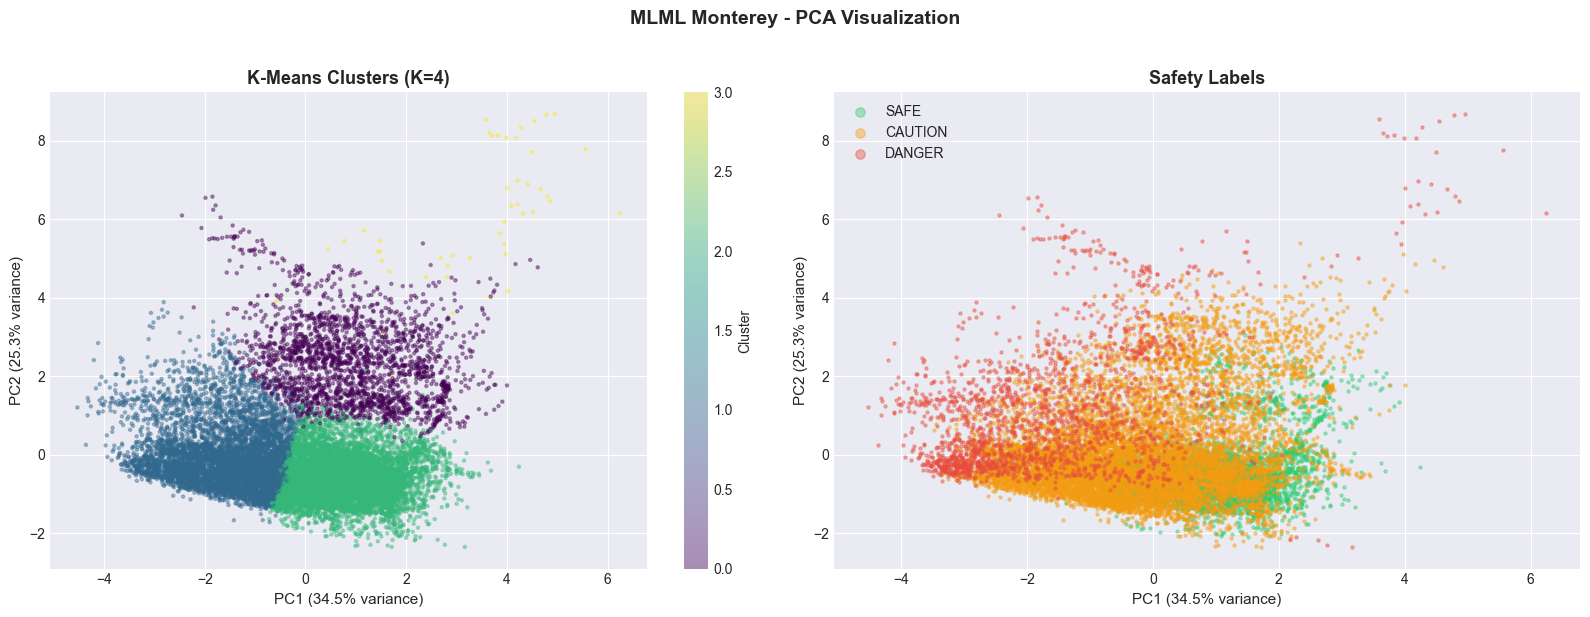

In [ ]:
# PCA visualization for MLML
pca = PCA(n_components=2, random_state=RANDOM_SEED)
mlml_pca = pca.fit_transform(mlml_X_scaled)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Colored by cluster
scatter1 = ax1.scatter(mlml_pca[:, 0], mlml_pca[:, 1], c=mlml_clusters,
                       cmap='viridis', alpha=0.4, s=5)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
ax1.set_title('K-Means Clusters (K=4)', fontsize=13, fontweight='bold')
plt.colorbar(scatter1, ax=ax1, label='Cluster')

# Plot 2: Colored by safety label
safety_colors = {0: '#2ecc71', 1: '#f39c12', 2: '#e74c3c'}
for label in [0, 1, 2]:
    mask = mlml_y_cluster.values == label
    label_name = ['SAFE', 'CAUTION', 'DANGER'][label]
    ax2.scatter(mlml_pca[mask, 0], mlml_pca[mask, 1],
               c=safety_colors[label], label=label_name, alpha=0.4, s=5)

ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
ax2.set_title('Safety Labels', fontsize=13, fontweight='bold')
ax2.legend(markerscale=3)

plt.suptitle('MLML Monterey - PCA Visualization', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

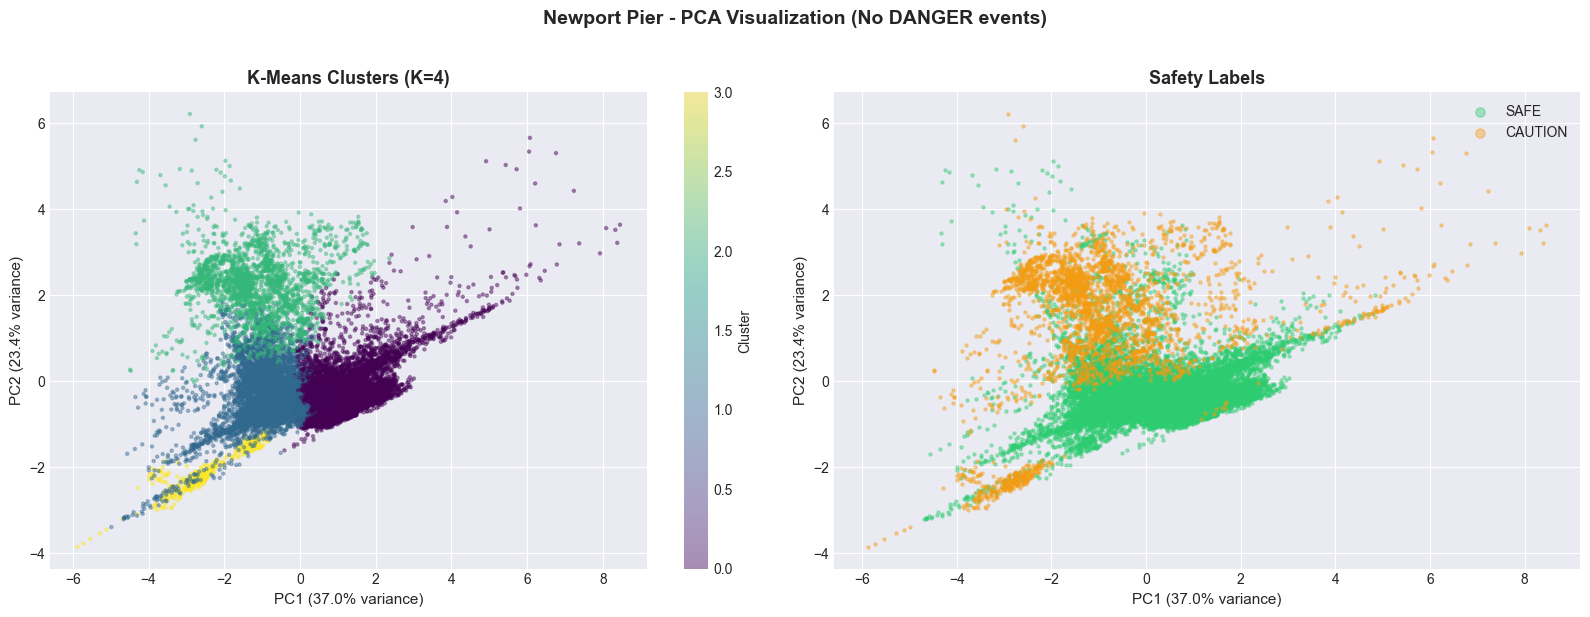

In [ ]:
# PCA visualization for Newport
pca = PCA(n_components=2, random_state=RANDOM_SEED)
newport_pca = pca.fit_transform(newport_X_scaled)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Colored by cluster
scatter1 = ax1.scatter(newport_pca[:, 0], newport_pca[:, 1], c=newport_clusters,
                       cmap='viridis', alpha=0.4, s=5)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
ax1.set_title('K-Means Clusters (K=4)', fontsize=13, fontweight='bold')
plt.colorbar(scatter1, ax=ax1, label='Cluster')

# Plot 2: Colored by safety label
for label in [0, 1]:
    mask = newport_y_cluster.values == label
    label_name = ['SAFE', 'CAUTION', 'DANGER'][label]
    ax2.scatter(newport_pca[mask, 0], newport_pca[mask, 1],
               c=safety_colors[label], label=label_name, alpha=0.4, s=5)

ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
ax2.set_title('Safety Labels', fontsize=13, fontweight='bold')
ax2.legend(markerscale=3)

plt.suptitle('Newport Pier - PCA Visualization (No DANGER events)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---

## Summary and Conclusions

### Key Findings from California Coastal Analysis

### Summary: California Coastal Water Quality Analysis

#### Data Overview
- **3 California coastal sites** analyzed
- **~3 years of data** per site (2023-2025)
- **~75,000+ hourly observations** total

#### Safety Classification

| Site | SAFE | CAUTION | DANGER | Notes |
|------|------|---------|--------|-------|
| MLML Monterey | 36.6% | 53.6% | 9.8% | Most variable (upwelling) |
| Scripps Pier | 64.2% | 32.0% | 3.7% | Moderate variability |
| Newport Pier | 84.4% | 15.6% | 0.0% | Most stable |

#### Primary Drivers by Site

| Site | Primary Driver | Correlation | Mechanism |
|------|----------------|-------------|-----------|
| MLML Monterey | Nitrate | r = +0.76 | Upwelling indicator |
| Scripps Pier | Chlorophyll | r = +0.67 | Algal blooms |
| Newport Pier | Chlorophyll | r = +0.86 | Algal blooms (very strong) |

#### Geographic Pattern
- **Northern CA (Monterey):** Driven by coastal upwelling
- **Southern CA (La Jolla, Newport):** Driven by algal blooms

#### Predictive Modeling Results
- Random Forest performed best across all sites
- 6-24 hour advance prediction is **feasible**
- Lagged features maintain strong correlations

#### Implications
1. Site-specific monitoring approaches needed
2. Northern CA: Monitor nitrate, DO, pH (upwelling signature)
3. Southern CA: Monitor chlorophyll (bloom indicator)
4. Early-warning systems are viable at all sites

### Research Question Answer

### Research Question Answer

**Question:** Can unsafe water conditions at California coastal sites be predicted in advance using oceanographic sensor data?

**Answer: YES.** This multi-site analysis demonstrates:

#### 1. Strong Predictive Signals Exist
| Site | Primary Predictor | Correlation |
|------|-------------------|-------------|
| Newport Pier | Chlorophyll | r = +0.86 (exceptionally strong) |
| Scripps Pier | Chlorophyll | r = +0.67 (strong) |
| MLML Monterey | Nitrate | r = +0.76 (strong) |

#### 2. Temporal Patterns Enable Forecasting
- **1-hour lag correlations:** 0.59 - 0.85
- **6-hour lag correlations:** 0.47 - 0.81
- **24-hour forecasts** are feasible at all sites

#### 3. Machine Learning Models Work
- Random Forest achieves 87-99% accuracy across sites
- DANGER recall is the critical metric for safety applications
- Classification is viable for early warning systems

#### 4. Site-Specific Approaches Required
- Different drivers at different latitudes
- One-size-fits-all approach won't work
- Local monitoring calibration is essential

---

## Data Sources & Attribution

| Site | Provider | Citation |
|------|----------|----------|
| **MLML Monterey** | CeNCOOS | Central & Northern CA Ocean Observing System. MLML Shore Station. |
| **Scripps Pier** | SCCOOS | Southern CA Coastal Ocean Observing System. Scripps Automated Shore Station. |
| **Newport Pier** | SCCOOS | Southern CA Coastal Ocean Observing System. Newport Pier Automated Shore Station. |

---

**End of Analysis**

For questions or collaboration: dzimmerman2021@fau.edu